In [1]:
import medspacy

from medspacy.ner import TargetRule
from medspacy.context import ConTextItem
from medspacy.visualization import visualize_ent, visualize_dep

In [2]:
nlp = medspacy.load()

In [3]:
nlp.pipe_names

['sentencizer',
 'tagger',
 'parser',
 'target_matcher',
 'sectionizer',
 'context',
 'postprocessor']

# I. Surgical site infection

In [4]:
texts = [
    "Fluid collection is seen in the abdomen.",
    "There is no evidence of fluid collection.",
    "PURPOSE OF EXAM: Rule out abscess.",
    "Hematomas are seen around in the right lower quadrant."
]

In [5]:
target_matcher = nlp.get_pipe("target_matcher")

In [6]:
target_rules = [
    TargetRule("fluid collection", "SSI"),
    TargetRule("hematoma", "SSI", pattern=[{"LOWER": {"REGEX": "hematoma"}}]),
    TargetRule("abscess", "SSI"),
    TargetRule("abdomen", "BODY_LOC", pattern=[{"LOWER": {"REGEX": "abd(omen)?"}}]),
    TargetRule("<LEFT/RIGHT> <UPPER/LOWER> quadrant", "BODY_LOC",
              pattern=[
                  {"LOWER": {"IN": ["left", "right"]}},
                  {"LOWER": {"IN": ["upper", "lower"]}},
                  {"LOWER": "quadrant"}
              ]),
]

In [7]:
target_matcher.add(target_rules)

In [8]:
docs = list(nlp.pipe(texts))

In [9]:
visualize_ent(docs[1])

In [10]:
visualize_dep(docs[1])

# II. COVID-19
https://openreview.net/pdf?id=ZQ_HvBxcdCv

In [11]:
nlp = medspacy.load()

In [12]:
texts = [
    "Patient admitted to hospital for respiratory failure secondary to COVID-19.",
    "The patient reports that they have been diagnosed with COVID-19",
    "Requested that patient be screened for novel coronavirus via telephone",
    "Lab Results: SARS-COV-2 DETECTED",
    "Patient does not have COVID-19",
    "This encounter is done over the telephone secondary to COVID-19 precautions.",
    
]

In [13]:
target_matcher = nlp.get_pipe("target_matcher")

In [14]:
target_rules = [
    TargetRule("COVID-19", "COVID-19"),
    TargetRule("SARS-COV-2", "COVID-19"),
    TargetRule("novel coronavirus", "COVID-19"),
]

In [15]:
target_matcher.add(target_rules)

In [16]:
context = nlp.get_pipe("context")

In [17]:
item_data = [
    ConTextItem("admitted to hospital for", "POSITIVE_EXISTENCE", rule="FORWARD"),
    ConTextItem("diagnosed with", "POSITIVE_EXISTENCE", rule="FORWARD"),
    ConTextItem("secondary to", "POSITIVE_EXISTENCE", rule="FORWARD"),
    ConTextItem("screened for", "UNCERTAIN", rule="FORWARD"),
    ConTextItem("DETECTED", "POSITIVE_EXISTENCE", rule="BACKWARD"),
    ConTextItem("precautions", "HYPOTHETICAL", rule="BIDIRECTIONAL"),
]

In [18]:
context.add(item_data)

In [19]:
docs = list(nlp.pipe(texts))

In [20]:
idx = 1

In [21]:
visualize_ent(docs[idx])

In [22]:
visualize_dep(docs[idx])

# III. i2b2
To train a statistical model, I used data from the i2b2 2012 shared task: [**"Evaluating temporal relations in clinical text"**](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3756273/). This model was trained on data for the first subtask in the shared task, referred to in the challenge as **"Clinically relevant events"**. For the purpose of this module, I specifically restricted it to the following labels of **clinical concepts**:
- **Problems:** Diagnoses, signs, and symptoms
- **Tests:** Lab and vital measurements
- **Treatments:** Medications, procedures, and therapies

**"en_info_3700_i2b2_2012"**

In [23]:
!pip install https://github.com/abchapman93/spacy_models/raw/master/releases/en_info_3700_i2b2_2012-0.1.0/dist/en_info_3700_i2b2_2012-0.1.0.tar.gz

  Using cached https://github.com/abchapman93/spacy_models/raw/master/releases/en_info_3700_i2b2_2012-0.1.0/dist/en_info_3700_i2b2_2012-0.1.0.tar.gz (12.3 MB)
  Created wheel for en-info-3700-i2b2-2012: filename=en_info_3700_i2b2_2012-0.1.0-py3-none-any.whl size=12270783 sha256=250da44e45082434edff58417a9e2c6adcba3ba9d1d3d4b8952730a3997dba40
  Stored in directory: /Users/alec/Library/Caches/pip/wheels/78/e8/22/863c5e1287f38607d2177f47f31cba9686310ab519d46ba4d9
Successfully built en-info-3700-i2b2-2012


In [156]:
nlp = medspacy.load("en_info_3700_i2b2_2012", disable=["sentencizer"])

In [157]:
nlp.pipe_names

['tagger',
 'parser',
 'ner',
 'target_matcher',
 'sectionizer',
 'context',
 'postprocessor']

In [158]:
ner = nlp.get_pipe("ner")

In [154]:
ner.labels

('PROBLEM', 'TEST', 'TREATMENT')

In [47]:
import pymysql
import getpass

In [48]:
conn = pymysql.connect(host="35.233.174.193",port=3306,
                           user="jovyan",passwd=getpass.getpass("Enter password for MIMIC2 database"),
                           db='mimic2')

Enter password for MIMIC2 database········


In [ ]:
!pip install pandas

  Using cached pandas-1.0.5-cp37-cp37m-macosx_10_9_x86_64.whl (10.0 MB)


In [54]:
import pandas as pd

In [147]:
query = """

SELECT subject_id, text
FROM noteevents
WHERE category = 'DISCHARGE_SUMMARY'
LIMIT 100;

"""
df = pd.read_sql(query, conn)

In [148]:
df.head()

,subject_id,text
0,56,\n \n \n \nAdmission Date: [**2644-1-17**] ...
1,37,\n\n\nAdmission Date: [**3264-8-14**] Dis...
2,78,\n\nAdmission Date: [**2778-3-24**] Dis...
3,26,\n\nAdmission Date: [**3079-3-3**] Discha...
4,12,\n\n\nAdmission Date: [**2875-9-26**] Dis...


In [149]:
text = df.iloc[1]["text"]

In [159]:
%%time
docs = list(nlp.pipe(df["text"]))

CPU times: user 50.1 s, sys: 6.98 s, total: 57.1 s
Wall time: 1min 3s


In [160]:
doc = docs[0]

In [161]:
visualize_ent(doc)

In [162]:
ents_data = []
for doc in docs:
    for ent in doc.ents:
        d = {
            "ent": ent,
            "text": ent.lower_,
            "label": ent.label_,
            "is_negated": ent._.is_negated,
            "is_family": ent._.is_family,
            "section_title": ent._.section_title
        }
        ents_data.append(d)

In [163]:
ents_df = pd.DataFrame(ents_data)

In [164]:
ents_df.head()

,ent,text,label,is_negated,is_family,section_title
0,"(Known, Allergies)",known allergies,PROBLEM,True,False,other
1,(Drugs),drugs,TREATMENT,True,False,other
2,"(Invasive, Procedure)",invasive procedure,TREATMENT,False,False,chief_complaint
3,(Age),age,TREATMENT,False,False,chief_complaint
4,"(lung, ca)",lung ca,PROBLEM,False,False,chief_complaint


In [165]:
import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
import seaborn as sns
sns.set()

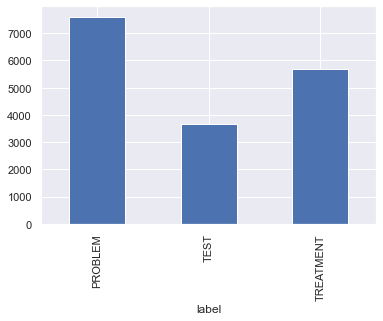

In [167]:
ents_df.groupby("label").size().plot.bar()

What problems occur most often in the PMH?

In [168]:
pmh = ents_df[(ents_df["section_title"] == "past_medical_history")
             &
             (ents_df["label"] == "PROBLEM")]

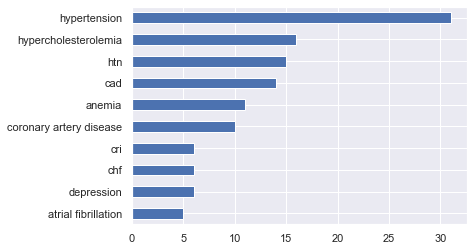

In [169]:
ax = pmh["text"].value_counts().iloc[:10].plot.barh()
ax.invert_yaxis()

Which problems occur most in family history?

In [170]:
fh = ents_df[(ents_df["is_family"] == True) | (ents_df["section_title"] == "family_history")]
fh = fh[fh["label"] == "PROBLEM"]

In [171]:
fh.head()

,ent,text,label,is_negated,is_family,section_title
182,"(coronary, artery, disease)",coronary artery disease,PROBLEM,False,True,medications
442,"(C, cirrhosis)",c cirrhosis,PROBLEM,False,True,past_medical_history
483,"(diabetes, \n, mellitus)",diabetes\nmellitus,PROBLEM,False,True,allergies
485,(cancer),cancer,PROBLEM,False,True,allergies
486,"(substance, abuse)",substance abuse,PROBLEM,True,True,allergies


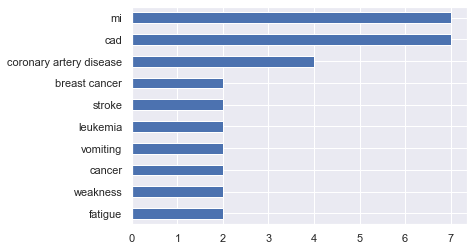

In [172]:
ax = fh["text"].value_counts().iloc[:10].plot.barh()
ax.invert_yaxis()